In [124]:
import gymnasium as gym
from adaptive_time.features import Fourier_Features
import numpy as np

import matplotlib.pyplot as plt
import random
import adaptive_time.utils

In [59]:
seed = 13

In [60]:
gym.register(
    id="CartPole-OURS-v0",
    entry_point="adaptive_time.environments.cartpole:CartPoleEnv",
    vector_entry_point="adaptive_time.environments.cartpole:CartPoleVectorEnv",
    max_episode_steps=500,
    reward_threshold=475.0,
)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [61]:
def reset_randomness(seed, env):
    random.seed(seed)
    np.random.seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)


In [62]:
env = gym.make('CartPole-OURS-v0')
tau = 0.02
env.stepTime(tau)


def generate_trajectory(env, policy=None):
    observation, _ = env.reset()
    trajectory = []
    terminated = False
    if policy is None:
        policy = lambda x: env.action_space.sample()
    while not terminated:
        action = policy(observation)
        observation_, reward, terminated, truncated, info = env.step(action)
        trajectory.append([observation, action, reward, observation_])
        observation = observation_

    return trajectory


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.stepTime to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.stepTime` for environment variables or `env.get_wrapper_attr('stepTime')` that will search the reminding wrappers.
  logger.warn(


In [63]:

reset_randomness(seed, env)
trajectory = generate_trajectory(env)

In [64]:
print(len(trajectory))
print(trajectory[0])

# seed = 13 should be:
# 16
# [array([0., 0., 0., 0.], dtype=float32), 1, 1.0, array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)]

16
[array([0., 0., 0., 0.], dtype=float32), 1, 1.0, array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)]


In [86]:
phi = Fourier_Features()
phi.init_fourier_features(4,3)
phi.init_state_normalizers(np.array([4.8,2.0,0.418,1]), np.array([-4.8,-2.0,-0.418,-1]))

In [87]:
phi.num_parameters

256

In [66]:


def ols_monte_carlo(env, phi, weights, targets, features, x0, gamma = 0.999):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    returns = []  # from x0 (the initial state)
    for t in range(N-1,-1,-1):
        state, _, reward, _ = trajectory[t]
        G = gamma*G + reward
        x = phi.get_fourier_feature(state)
        if np.linalg.norm(x-x0) < 0.00001:
            returns.append(G)
        features += np.outer(x,x)
        targets += G * x
    weights = np.linalg.solve(features, targets)
    return weights, targets, features, np.mean(returns)


def gradient_monte_carlo(env, phi, weights, x0, gamma = 1, alpha = 0.001):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    returns = []
    for t in range(N-1,-1,-1):
        state, _, reward, _ = trajectory[t]
        G = gamma * G + reward
        x = phi.get_fourier_feature(state)
        if np.linalg.norm(x-x0) < 0.00001:
            returns.append(G)
        weights = weights + alpha * (G - np.inner(x, weights)) * x 
    return weights, np.mean(returns)




num_episodes = 1000
returns = []
average_returns = []
predicted_returns = []

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((d,d))   # An estimate of A = xx^T
targets = np.zeros(d)  # An estimate of b = xG
weights = np.zeros(d)   # The weights that approximate A^{-1} b
x = phi.get_fourier_feature([0,0,0,0])  # the initial state
for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo(
        env, phi, weights, targets, features, x)
    if cur_avr_returns:
        # When we are starting from the fixed initial state, this
        # should always be true!
        returns.append(cur_avr_returns)
    if returns:
        average_returns.append(np.mean(returns))
        pred_return = np.inner(x, weights)
        predicted_returns.append(pred_return)
        print(
            'episode:', episode,
            ' empirical returns:' , np.mean(returns),
            ' predicted returns:' , pred_return)

episode: 0  empirical returns: 15.880558184360002  predicted returns: 15.880558184360751
episode: 1  empirical returns: 16.372617905267823  predicted returns: 16.37261790526668
episode: 2  empirical returns: 18.8237497423018  predicted returns: 18.82374974234847
episode: 3  empirical returns: 24.40540453558862  predicted returns: 24.405425579316216
episode: 4  empirical returns: 22.306196228670693  predicted returns: 22.30617519034422
episode:

 5  empirical returns: 22.705544757717806  predicted returns: 22.590263845399022
episode: 6  empirical returns: 21.730546675809553  predicted returns: 21.758410533424467
episode: 7  empirical returns: 21.36797398328347  predicted returns: 21.275481957825832
episode: 8  empirical returns: 20.8676077213826  predicted returns: 21.024954640306532
episode: 9  empirical returns: 20.859979352773827  predicted returns: 21.385753076523542
episode: 10  empirical returns: 21.03168688238969  predicted returns: 28.440553039312363
episode: 11  empirical returns: 20.766364054569667  predicted returns: 17.425056781619787
episode: 12  empirical returns: 20.46623432930859  predicted returns: 20.47615453787148
episode: 13  empirical returns: 19.997886377286477  predicted returns: 24.01695434935391
episode: 14  empirical returns: 20.24642817989203  predicted returns: 17.872367694973946
episode: 15  empirical returns: 21.131744728837248  predicted returns: 22.019642805680633
episode: 16  empirical returns:

In [67]:
def plot_est_vs_pred(tuples_of_y_and_labels_and_kwargs, title=None, show=True):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for y, label, kwargs in tuples_of_y_and_labels_and_kwargs:
        plt.plot(y, label=label, **kwargs)

    # if ylim:
    #     plt.ylim(-0.05, 0.5)
    # ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    # plt.xlim(-1000, 80_000)

    plt.ylabel('Episode\nReturn', rotation=0, labelpad=40)
    plt.xlabel('Number of Episodes')
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax


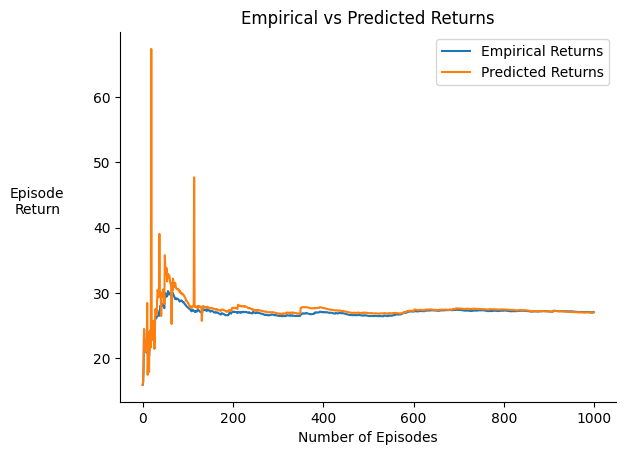

<Axes: title={'center': 'Empirical vs Predicted Returns'}, xlabel='Number of Episodes', ylabel='Episode\nReturn'>

In [68]:

plot_est_vs_pred([
   (average_returns, 'Empirical Returns', {}),
   (predicted_returns, 'Predicted Returns', {})],
   title='Empirical vs Predicted Returns')


## Q-function estimation

Like above, but now learn per-action returns. The strategy is the same, but instead of using `v(s) = phi(s)' w`, we use `q(s, a) = phi(s, a)' w`.

We'll use `phi(s, a) = [ 1_{a=0}*phi(s), 1_{a=1}*phi(s) ]`, so basically each action gets its own weights.

In [136]:
def phi_sa(phi_x, a, prev_phi_sa=None):
    """Form the (state, action) feature, potentially reusing memory.
    
    - phi_x: the state feature
    - a: the action
    - prev_phi_sa: the previous state,action feature, which can be
      reused to avoid memory allocation.

    Returns the feature as a (2, d) array. Use a flat copy.
    """
    if prev_phi_sa is not None:
        prev_phi_sa.fill(0)
        phi_sa = prev_phi_sa
    else:
        phi_sa = np.zeros((2, phi_x.size))
    phi_sa[a] = phi_x
    return phi_sa


def ols_monte_carlo_q(
        env, phi, weights, targets, features, x0, policy=None, print_trajectory=False, gamma = 0.999):
    trajectory = generate_trajectory(env, policy=policy)
    if print_trajectory:
        print("trajectory-len: ", len(trajectory), "; trajectory:")
        for idx, (o, a, r, o_) in enumerate(trajectory):
            # * ignore reward, as it is always the same here.
            # * o_ is the same as the next o.
            print(f"* {idx:4d}: o: {o}\n\t --> action: {a}")
    N = len(trajectory)
    G = 0
    x_sa = np.zeros((2, phi.num_parameters))
    returns_a0 = []  # from x0 (the initial state), action 0
    returns_a1 = []  # from x0 (the initial state), action 1
    for t in range(N-1,-1,-1):
        state, action, reward, _ = trajectory[t]
        G = gamma*G + reward
        x = phi.get_fourier_feature(state)
        # Record empirical returns.
        if np.linalg.norm(x-x0) < 0.00001:
            if action == 0:
                returns_a0.append(G)
            elif action == 1:
                returns_a1.append(G)

        x_sa = phi_sa(x, action, x_sa)
        x_sa_flat = x_sa.flatten()

        features += np.outer(x_sa_flat, x_sa_flat)
        targets += G * x_sa_flat
    try:
        weights = np.linalg.solve(features, targets)
    except np.linalg.LinAlgError:
        print("Singular matrix in OLS. Using previous weights.")
    return weights, targets, features, (np.mean(returns_a0), np.mean(returns_a1))



### Run Q-function estimation

In [83]:

num_episodes = 2000

# We record:
returns_per_episode_q = np.zeros((2, num_episodes))
average_returns_q = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((2 * d, 2 * d))   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q[:, episode] = cur_avr_returns
    average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)

    predicted_returns_q[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , average_returns_q[:, episode],
        ' predicted returns:' , predicted_returns_q[:, episode])

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_47411/2627431572.py:29: RuntimeWarning: Mean of empty slice
  average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)


episode: 0  empirical returns: [        nan 15.88055818]  predicted returns: [10.95103416 15.88055818]
episode: 1  empirical returns: [        nan 16.37261791]  predicted returns: [-1.31849548 16.37193275]
episode: 2  empirical returns: [        nan 18.82374974]  predicted returns: [1164.07203981   18.88933872]
episode: 3  empirical returns: [        nan 24.40540454]  predicted returns: [38.01746713 26.70878241]
episode: 4  empirical returns: [        nan 22.30619623]  predicted returns: [39.06190954 25.1229462 ]
episode: 5  empirical returns: [24.7022874  22.30619623]  predicted returns: [28.1099995  25.11725516]
episode: 6  empirical returns: [20.29142279 22.30619623]  predicted returns: [24.6081939  24.32684073]
episode: 7  empirical returns: [20.29142279 21.72682438]  predicted returns: [24.69115603 23.88975411]
episode: 8  empirical returns: [20.29142279 21.03223199]  predicted returns: [24.57487765 23.29796686]
episode: 9  empirical returns: [20.45805654 21.03223199]  predicted r

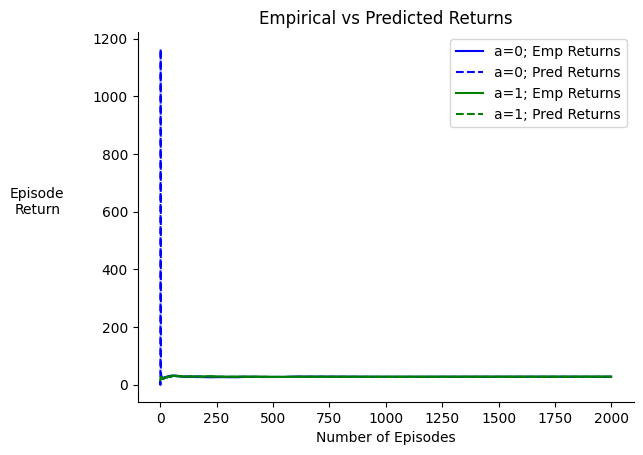

<Axes: title={'center': 'Empirical vs Predicted Returns'}, xlabel='Number of Episodes', ylabel='Episode\nReturn'>

In [84]:

plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='Empirical vs Predicted Returns',
   show=True)



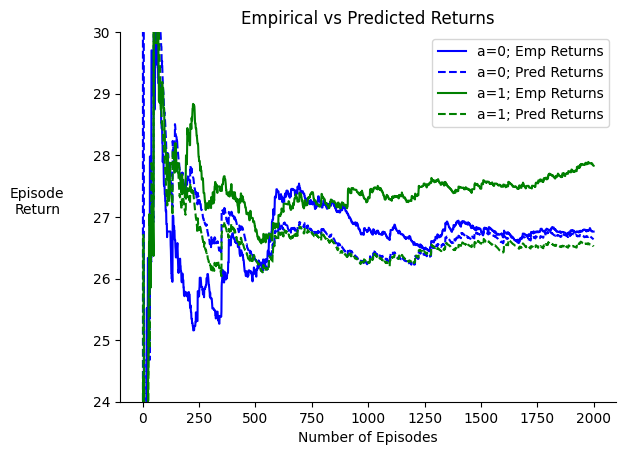

In [85]:

ax = plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='Empirical vs Predicted Returns',
   show=False)

ax.set_ylim(24, 30)
plt.show()


### Evaluate a more interesting policy (back-and-forth)

Simple control: if on one side, push the other way, if on other side, push back against it.

In [116]:

num_episodes = 100

# We record:
returns_per_episode_q_bf = np.zeros((2, num_episodes))
average_returns_q_bf = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q_bf = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((2 * d, 2 * d))   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

def policy(observation):
    if observation[2] < 0:
        return 0
    else:
        return 1

for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0, policy=policy)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q_bf[:, episode] = cur_avr_returns
    average_returns_q_bf[:, episode] = np.nanmean(returns_per_episode_q_bf[:, :episode+1], axis=1)

    predicted_returns_q_bf[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q_bf[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , average_returns_q_bf[:, episode],
        ' predicted returns:' , predicted_returns_q_bf[:, episode])

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_47411/1787793075.py:35: RuntimeWarning: Mean of empty slice
  average_returns_q_bf[:, episode] = np.nanmean(returns_per_episode_q_bf[:, :episode+1], axis=1)


episode: 0  empirical returns: [         nan 501.09906592]  predicted returns: [165761.86159203    501.09914062]
episode: 1  empirical returns: [         nan 501.09906592]  predicted returns: [47488.3737263   501.099097 ]
episode: 2  empirical returns: [         nan 501.09906592]  predicted returns: [8.02474524e+06 5.01098941e+02]
episode: 3  empirical returns: [         nan 501.09906592]  predicted returns: [-10071.97105164    501.09914459]
episode: 4  empirical returns: [         nan 501.09906592]  predicted returns: [160158.52808943    501.09916424]
episode: 5  empirical returns: [         nan 501.09906592]  predicted returns: [-5.27331032e+06  5.01099295e+02]
episode: 6  empirical returns: [         nan 501.09906592]  predicted returns: [198641.51386343    501.09918533]
episode: 7  empirical returns: [         nan 501.09906592]  predicted returns: [46738.37322639   501.09929717]
episode: 8  empirical returns: [         nan 501.09906592]  predicted returns: [77809.86819887   501.099

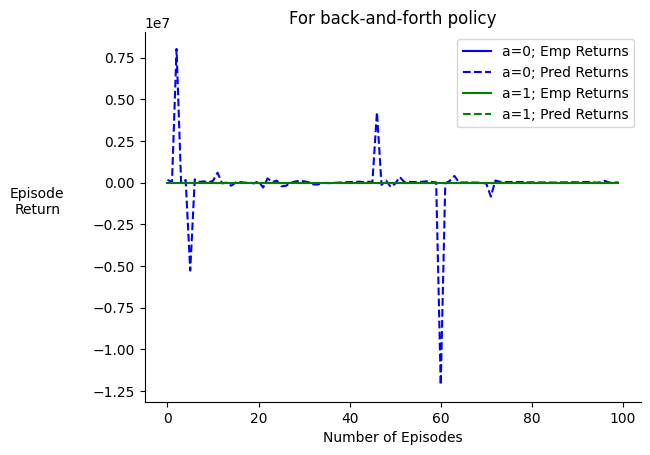

In [119]:

ax = plot_est_vs_pred([
      (average_returns_q_bf[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q_bf[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q_bf[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q_bf[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='For back-and-forth policy',
   show=False)

# ax.set_ylim(32, 33)
plt.show()

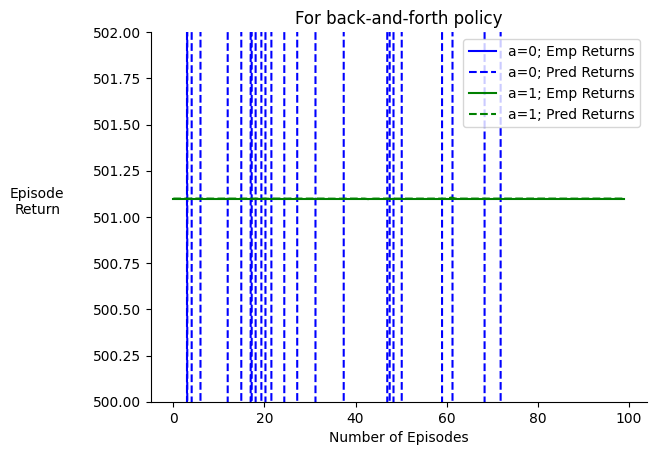

In [122]:

ax = plot_est_vs_pred([
      (average_returns_q_bf[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q_bf[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q_bf[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q_bf[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='For back-and-forth policy',
   show=False)

ax.set_ylim(500, 502)
plt.show()


## MC Control

The strategy is:

1. Initialize Q values with weight = 0; policy is always eps-greedy wrt Q.
2. Repeat until convergence (?):
3.      MC evaluation of current policy, updates Q-values

Note that this strategy implicitly uses 1 episode evaluation per each improvement step.
See Sutton & Barto p99, Monte-Carlo ES control, for a similar algorithm, one that uses
exploring starts instead of soft-policies for coverage.

Another possible variant: use temperature.

In [138]:

num_episodes = 500
epsilon = 0.1

# We record:
returns_per_episode_q = np.zeros((2, num_episodes))
average_returns_q = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((2 * d, 2 * d))   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

for episode in range(num_episodes):
    def policy(state):
        if random.random() < epsilon:
            return env.action_space.sample()
        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(2)
        for action in [0, 1]:
            x_sa = phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        return adaptive_time.utils.argmax(qs)

    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0, policy=policy, print_trajectory=False)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q[:, episode] = cur_avr_returns
    average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)

    predicted_returns_q[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , average_returns_q[:, episode],
        ' predicted returns:' , predicted_returns_q[:, episode])

Singular matrix in OLS. Using previous weights.
episode: 0  empirical returns: [13.909363       nan]  predicted returns: [0. 0.]
episode: 1  empirical returns: [45.87652228         nan]  predicted returns: [45.87652228 42.11259287]
episode: 2  empirical returns: [38.49301933         nan]  predicted returns: [   38.49302061 -8282.25430717]


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_47411/1475026810.py:42: RuntimeWarning: Mean of empty slice
  average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)


episode: 3  empirical returns: [277.75487631          nan]  predicted returns: [ 195.02879438 2848.02180132]
episode: 4  empirical returns: [277.75487631  14.89545364]  predicted returns: [ 190.30916943 -145.66108441]
episode: 5  empirical returns: [234.04499586  14.89545364]  predicted returns: [450.41121858  26.16294473]
episode: 6  empirical returns: [197.84827615  14.89545364]  predicted returns: [ 165.87092336 -152.36372748]
episode: 7  empirical returns: [171.85288787  14.89545364]  predicted returns: [106.35843491 -18.41182085]
episode: 8  empirical returns: [156.94546325  14.89545364]  predicted returns: [103.17667084  97.9426607 ]
episode: 9  empirical returns: [143.11568015  14.89545364]  predicted returns: [ 163.13801622 -592.15751245]
episode: 10  empirical returns: [133.30211395  14.89545364]  predicted returns: [147.61383939 -66.83056112]
episode: 11  empirical returns: [123.07386032  14.89545364]  predicted returns: [129.91998882   1.31036681]
episode: 12  empirical retu

KeyboardInterrupt: 

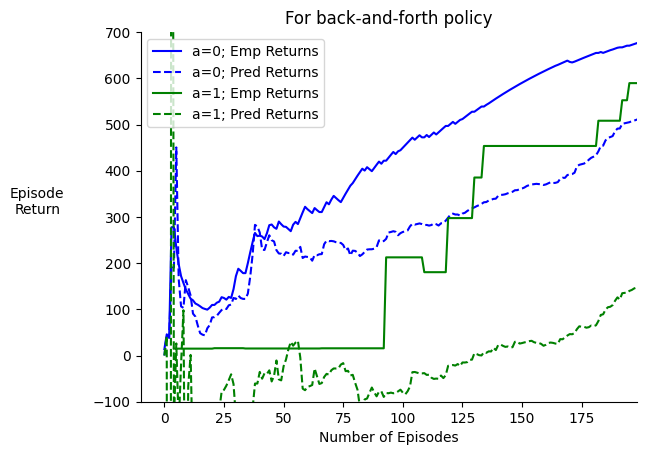

In [148]:

ax = plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='For back-and-forth policy',
   show=False)

ax.set_ylim(-100, 700)
ax.set_xlim(-10, 198)
plt.show()

In [139]:
def policy(state, weights, epsilon=0.1):
    if random.random() < epsilon:
        return env.action_space.sample()
    # Otherwise calculate the best action.
    x = phi.get_fourier_feature(state)
    qs = np.zeros(2)
    for action in [0, 1]:
        x_sa = phi_sa(x, action)
        qs[action] = np.inner(x_sa.flatten(), weights)
    # adaptive_time.utils.softmax(qs, 1)
    return adaptive_time.utils.argmax(qs)

traj = generate_trajectory(env, policy=lambda o: policy(o, weights=weights, epsilon=0.1))

In [140]:
len(traj)

2625

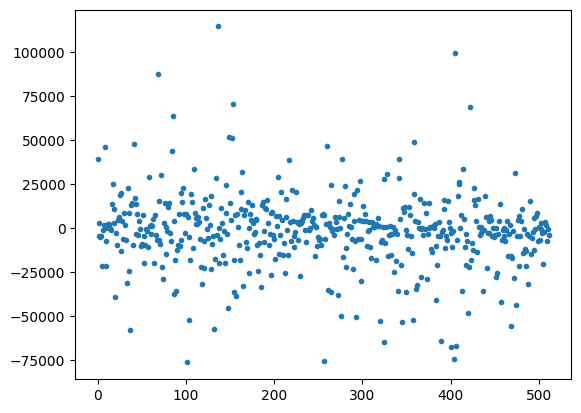

In [152]:
plt.plot(weights, '.')

(array([  9.,  14.,  51., 196., 194.,  31.,  11.,   3.,   1.,   2.]),
 array([-7.62428699e+04, -5.71669468e+04, -3.80910237e+04, -1.90151007e+04,
         6.08224116e+01,  1.91367455e+04,  3.82126686e+04,  5.72885916e+04,
         7.63645147e+04,  9.54404378e+04,  1.14516361e+05]),
 <BarContainer object of 10 artists>)

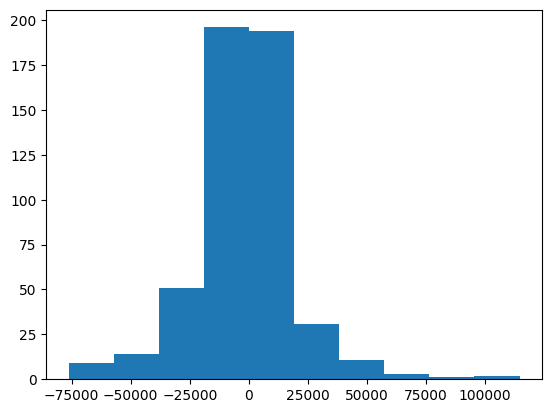

In [153]:
plt.hist(weights)

### Running for longer?

## Random Tests

In [73]:
testx = np.array([
    [1, 2, 3],
    [10, 20, 30]
])
print(testx)

print(testx.flatten())

[[ 1  2  3]
 [10 20 30]]
[ 1  2  3 10 20 30]


In [74]:
testy = np.array([
    [1, 0, 0],
    [np.nan, 0, 0]
])

ep = 1
testy[:, ep] = (np.nan, 20)  
print(testy)
print(np.nanmean(testy[:, :ep+1], axis=1))



[[ 1. nan  0.]
 [nan 20.  0.]]
[ 1. 20.]


In [75]:
a = testx
a.fill(0)
print(a)
print(testx)

[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]


In [76]:
if np.mean([]):
    print("mean exists")
else:
    print("mean does not exist")

mean exists


In [77]:
testx[:, 0] = (0, 0)
print(testx)

[[0 0 0]
 [0 0 0]]


In [78]:
trajectory

[[array([0., 0., 0., 0.], dtype=float32),
  1,
  1.0,
  array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)],
 [array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32),
  1,
  1.0,
  array([ 0.00390244,  0.3902439 , -0.00585366, -0.58536583], dtype=float32)],
 [array([ 0.00390244,  0.3902439 , -0.00585366, -0.58536583], dtype=float32),
  1,
  1.0,
  array([ 0.01170732,  0.5854474 , -0.01756098, -0.879887  ], dtype=float32)],
 [array([ 0.01170732,  0.5854474 , -0.01756098, -0.879887  ], dtype=float32),
  1,
  1.0,
  array([ 0.02341626,  0.78080344, -0.03515872, -1.        ], dtype=float32)],
 [array([ 0.02341626,  0.78080344, -0.03515872, -1.        ], dtype=float32),
  0,
  1.0,
  array([ 0.03903233,  0.5861686 , -0.05515872, -0.7185627 ], dtype=float32)],
 [array([ 0.03903233,  0.5861686 , -0.05515872, -0.7185627 ], dtype=float32),
  1,
  1.0,
  array([ 0.05075571,  0.78200865, -0.06952997, -1.        ], dtype=float32)],
 [array([ 0.05075571, 